## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [1]:
# !gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings
!gdown 18Z7QuFLJFL18xrxKWdqWgLcAgvGJDWJV

Downloading...
From: https://drive.google.com/uc?id=18Z7QuFLJFL18xrxKWdqWgLcAgvGJDWJV
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:02<00:00, 29.0MB/s]


In [2]:
# !gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings
!gdown 1BBXx3wmO6s4Zjn-E4nIWmcBIpGmyedPM

Downloading...
From (original): https://drive.google.com/uc?id=1BBXx3wmO6s4Zjn-E4nIWmcBIpGmyedPM
From (redirected): https://drive.google.com/uc?id=1BBXx3wmO6s4Zjn-E4nIWmcBIpGmyedPM&confirm=t&uuid=c6093fec-d388-42f3-bf6a-4f9d42abbe4f
To: /content/coco_captions.npy
100% 415M/415M [00:05<00:00, 79.7MB/s]


In [3]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.j

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [5]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

coco_dset1 = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json')

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [6]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [7]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [8]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [9]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [10]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre)
        accuracy += score
    return accuracy/len(predict)

In [11]:
import random
def nearest_img_indices(i,k):
  sample_image_emb = image_embeddings[i]
  sample_image_cap = captions_np[i]
  if i=="IndexHNSWFlat":
    index = faiss.IndexFlatL2(512,k)
  else:
    index = faiss.IndexFlatL2(512)
  index.add(image_embeddings)
  query = sample_image_emb.reshape(1,-1)
  distances, indices = index.search(query,k+1)
  indices = indices[:,1:]
  indices = indices[0]
  return sample_image_emb,indices,sample_image_cap

def cosine_similarity(u, v):
    dot_product = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    similarity = dot_product / (norm_u * norm_v)
    return similarity

def find_query_vector(indices,k,sample_image_emb):
  query_vector = np.zeros(512)
  # print(indices)

  for i in indices:
    for j in range(5):
      query_vector = query_vector + (cosine_similarity(sample_image_emb, image_embeddings[i])*caption_embeddings[i][j])
  divisor = k*5
  new_query_vector = query_vector / divisor
  return new_query_vector

def find_best_caption(query_vector,indices):
  best_caption = ""
  max_sim = -10
  for i in indices:
    for j in range(5):
      sim = cosine_similarity(query_vector,caption_embeddings[i][j])
      if np.any(sim > max_sim):
        max_sim = sim
        best_caption = captions_np[i][j]
  return best_caption

sample_img_indices = [random.randint(0, len(coco_dset)) for _ in range(1000)]

def accuracy_v2(predict, real):
    lower_n_split = lambda x: x.lower().split()
    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

# sample_img_indices=[0,1,2,3,4]


In [12]:
def find_caption(idx,k):
  predicted = []
  real = []
  for val in sample_img_indices:
    sample_image_emb,indices,sample_image_cap = nearest_img_indices(val,k)
    query_vector = find_query_vector(indices,k,sample_image_emb)
    best_caption = find_best_caption(query_vector,indices)
    predicted.append(best_caption)
    real.append(sample_image_cap)
  a = accuracy_v2(predicted, real)
  return a


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

[0.0596281802640799, 0.06611332562927014, 0.07076763080514506, 0.07550708212877784, 0.07676710184629212, 0.07663266277704511, 0.08031082912078079, 0.07496298778709229, 0.07360895786684116, 0.07264214387512898]


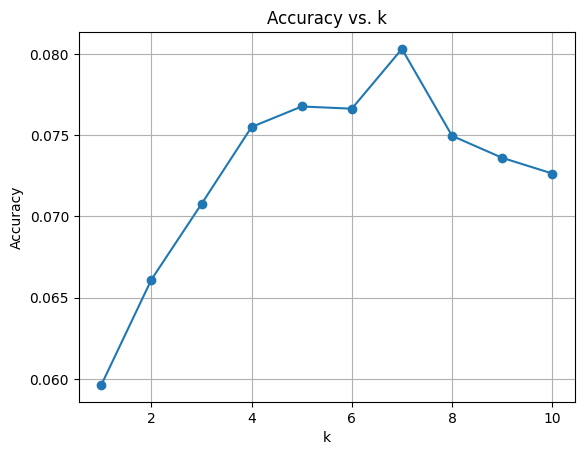

In [ ]:
import matplotlib.pyplot as plt
acc = []
K = [1,2,3,4,5,6,7,8,9,10]
for k in K:
  acc.append(find_caption("IndexFlatL2",k))
print(acc)
plt.plot(K, acc, marker='o')
plt.title('Accuracy vs. k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
k = 7
acc1 = find_caption("IndexFlatL2",k)
acc2 = find_caption("IndexFlatIP",k)
acc3 = find_caption("IndexHNSWFlat",k)
print("accuracy for IndexFlatL2", acc1)
print("accuracy for IndexFlatIP", acc2)
print("accuracy for IndexHNSWFlat", acc3)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

accuracy for IndexFlatL2 0.07272340973166383
accuracy for IndexFlatIP 0.07272340973166383
accuracy for IndexHNSWFlat 0.07272340973166383


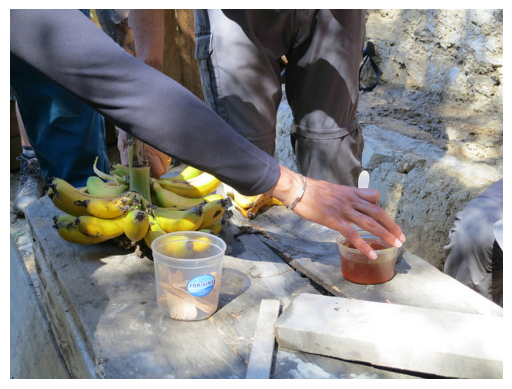

['A woman touching a plastic container sitting on a table.'
 'There are a bunch of bananas left out in the open. '
 'some people a table some bananas and plastic cups'
 'A table with bananas close to the road.'
 'A person reaches for a container on a counter. ']
Some food and other items sitting on the ground.


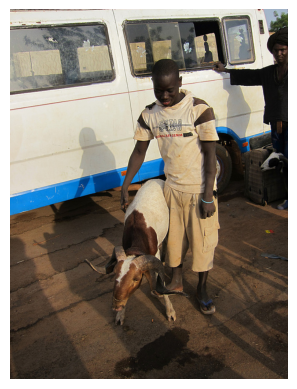

['A boy that is standing next to an animal.'
 'A photo of a man standing with a ram.'
 'A boy guides a small animal away from a vehicle.'
 'A young man is standing next to a goat.'
 'A young man standing in front of a bus, is petting the baby steer. ']
A man sitting on a cart being pulled by cows.


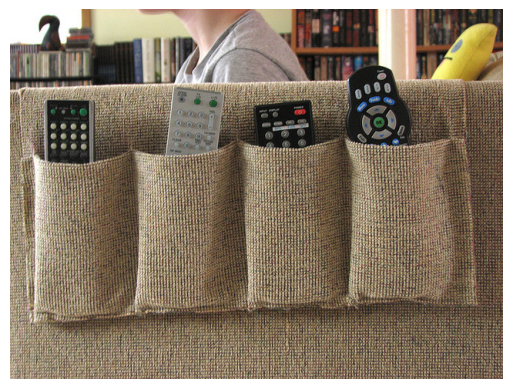

['A bunch of remotes that are in cloth holders.'
 'four different controllers in a couches controller case and a person'
 'The four remotes are inside of pockets on the arm of a couch.'
 'A remote control storage pouch attached to a couch. '
 'a remote control holder attached to living room furniture that is full of controllers']
Microwave sitting on a counter with other kitchen furnishings around it


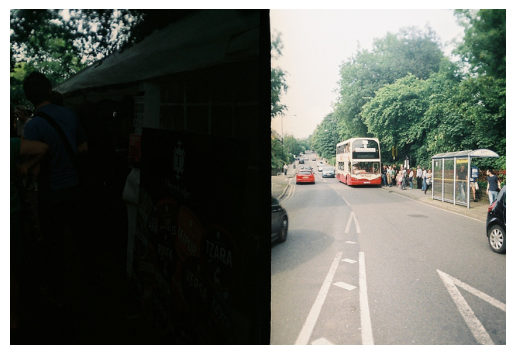

['A street with busses and cars next to a bus stop.'
 'Two photographs: dark one of a village and a bustling city street'
 'A bus coming up the road to stop at a bus stop.'
 'A double decker bus is approaching a bus stop.'
 'A picture of some people near a building next to a picture of some vehicles on a road.']
An intersection with traffic lights, no traffic and cones in the street. 


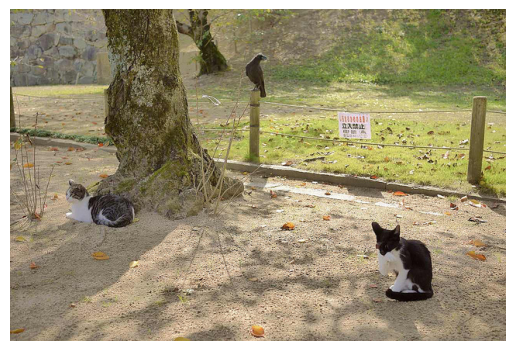

['Two cats sitting in the dirt under a tree.'
 'A couple of cats are by a tree' 'an image of two cats in a sand lot'
 'Two cats by a tree in the dirt'
 'Several cats sitting near a tree and a bird on a fence post.']
A cat sitting on the ground while another cat sits on a bench.


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

4.068524596185286e-155

In [15]:
import matplotlib.pyplot as plt
n = 5
sample_img_indices = [random.randint(0, len(coco_dset)) for _ in range(n)]

def Qualitative(idx,k):
  predicted = []
  real = []
  for val in sample_img_indices:
    sample_image_emb,indices,sample_image_cap = nearest_img_indices(val,k)
    query_vector = find_query_vector(indices,k,sample_image_emb)
    best_caption = find_best_caption(query_vector,indices)
    predicted.append(best_caption)
    real.append(sample_image_cap)
    img, target = coco_dset1[val]
    plt.imshow(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(captions_np[val])
    print(best_caption)
  a = accuracy_v2(predicted, real)
  return a

Qualitative("IndexFlatL2",7)